<a href="https://colab.research.google.com/github/astutisingh/FakeNewsAnalyzer/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# Read datasets
fake = pd.read_csv("https://github.com/FavioVazquez/fake-news/raw/master/data/Fake.csv")
true = pd.read_csv("https://github.com/FavioVazquez/fake-news/raw/master/data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

### Data Cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Oklahoma governor wants to use reserve fund to...,SAN FRANCISCO (Reuters) - Oklahoma Governor Ma...,politicsNews,"March 8, 2016",true
1,Israel disappointed at Trump's decision not to...,JERUSALEM (Reuters) - Israel on Thursday expre...,politicsNews,"June 1, 2017",true
2,Crowd Scientists Have BAD News For Trump Over...,Team Trump is having a war on math. Alleged pr...,News,"January 22, 2017",fake
3,Trump nominates businessman with Asia backgrou...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"January 25, 2017",true
4,'Rage against the machine': U.S. voters reject...,(This November 9th story has been refiled to ...,politicsNews,"November 9, 2016",true


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Oklahoma governor wants to use reserve fund to...,SAN FRANCISCO (Reuters) - Oklahoma Governor Ma...,politicsNews,true
1,Israel disappointed at Trump's decision not to...,JERUSALEM (Reuters) - Israel on Thursday expre...,politicsNews,true
2,Crowd Scientists Have BAD News For Trump Over...,Team Trump is having a war on math. Alleged pr...,News,fake
3,Trump nominates businessman with Asia backgrou...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
4,'Rage against the machine': U.S. voters reject...,(This November 9th story has been refiled to ...,politicsNews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,SAN FRANCISCO (Reuters) - Oklahoma Governor Ma...,politicsNews,true
1,JERUSALEM (Reuters) - Israel on Thursday expre...,politicsNews,true
2,Team Trump is having a war on math. Alleged pr...,News,fake
3,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
4,(This November 9th story has been refiled to ...,politicsNews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,san francisco (reuters) - oklahoma governor ma...,politicsNews,true
1,jerusalem (reuters) - israel on thursday expre...,politicsNews,true
2,team trump is having a war on math. alleged pr...,News,fake
3,washington (reuters) - u.s. president donald t...,politicsNews,true
4,(this november 9th story has been refiled to ...,politicsNews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,san francisco reuters oklahoma governor mary ...,politicsNews,true
1,jerusalem reuters israel on thursday expresse...,politicsNews,true
2,team trump is having a war on math alleged pre...,News,fake
3,washington reuters us president donald trump ...,politicsNews,true
4,this november 9th story has been refiled to c...,politicsNews,true


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,san francisco reuters oklahoma governor mary f...,politicsNews,true
1,jerusalem reuters israel thursday expressed di...,politicsNews,true
2,team trump war math alleged president donald t...,News,fake
3,washington reuters us president donald trump w...,politicsNews,true
4,november 9th story refiled clarify keyes comme...,politicsNews,true


### Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


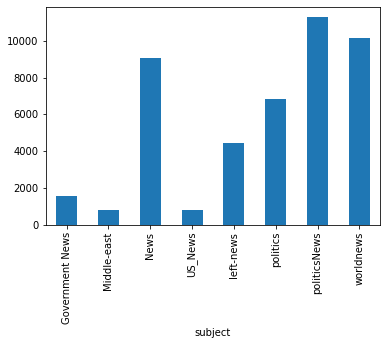

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


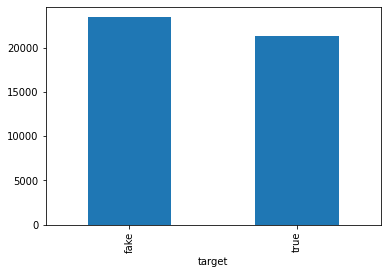

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

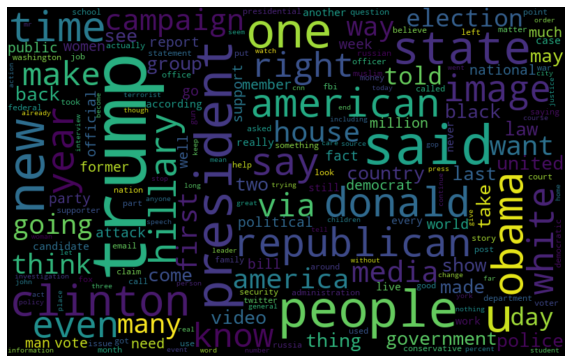

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

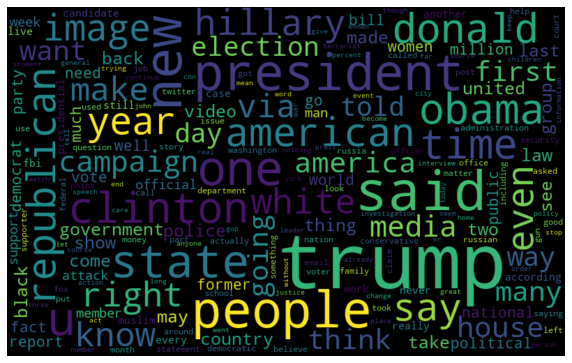

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

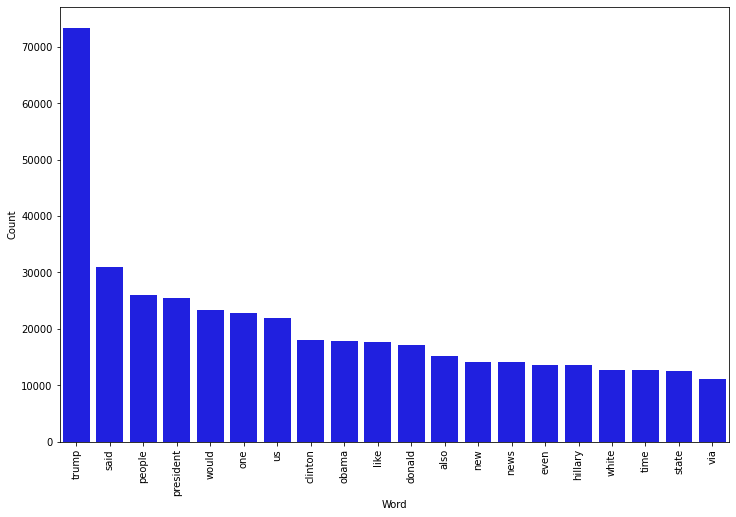

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

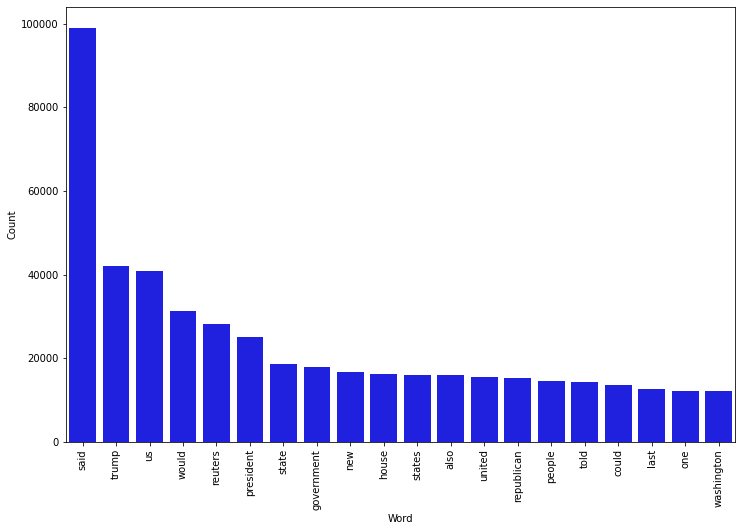

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

### Modeling

In [23]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Preparing the data

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.65%


Confusion matrix, without normalization


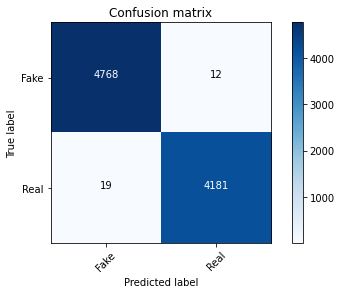

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])